<a href="https://colab.research.google.com/github/josebenitezg/Pytorch-Image-Segmentation/blob/main/Learn_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up colab GPU runtime environment


In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/josebenitezg/Pytorch-Image-Segmentation

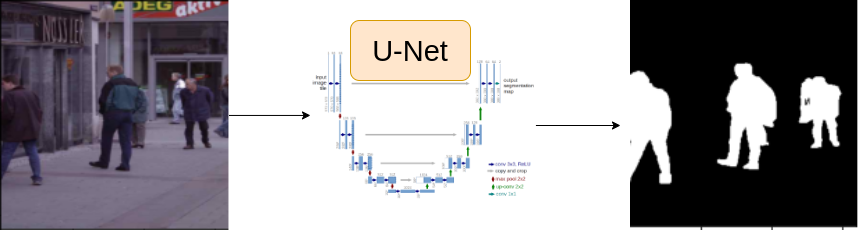

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Pytorch-Image-Segmentation')

In [14]:
import torch 
import cv2

import numpy as np 
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Setup Configurations

In [4]:
CSV_FILE = '/content/Pytorch-Image-Segmentation/dataset/train.csv'
DATA_DIR = '/content/Pytorch-Image-Segmentation/dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320

BATCH_SIZE = 64

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

In [18]:
def change_path(df, new_path):
    # Update the paths in the 'masks' and 'images' columns
    df['masks'] = df['masks'].str.replace('./dataset/', new_path, regex=False)
    df['images'] = df['images'].str.replace('./dataset/', new_path, regex=False)

    return df


In [20]:
new_path = '/content/Pytorch-Image-Segmentation/dataset/'

df = change_path(df, new_path)

row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

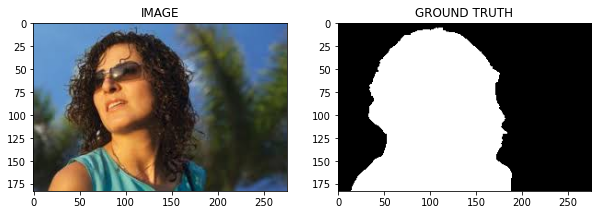

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [22]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [23]:
import albumentations as A

In [24]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

# Task 4 : Create Custom Dataset 

In [25]:
from torch.utils.data import Dataset

In [26]:
class SegmentationDataset(Dataset):
  
  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    # Resize the mask to the same dimensions as the image
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST) # (h, w)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [28]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [29]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


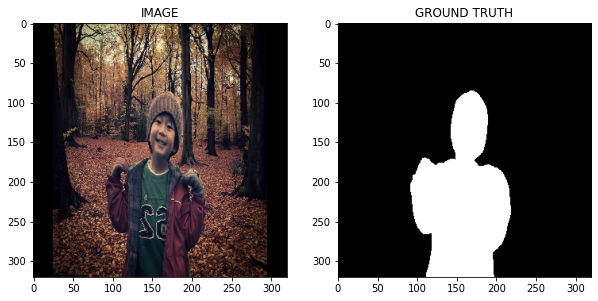

In [30]:
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

idx = 21

image, mask = trainset[idx]
show_image(image, mask)

# Task 5 : Load dataset into batches

In [31]:
from torch.utils.data import DataLoader

In [32]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [33]:
print(f"Total n of batches in trainloader: {len(trainloader)}")
print(f"Total n of batches in validloader: {len(validloader)}")

Total n of batches in trainloader: 4
Total n of batches in validloader: 1


In [34]:
for image, mask in trainloader:
  break
print(f"One batch image shape: {image.shape}")
print(f"One batch image shape: {mask.shape}")

One batch image shape: torch.Size([64, 3, 320, 320])
One batch image shape: torch.Size([64, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [35]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [36]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    
    return logits


In [37]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function 

In [38]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in data_loader:

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    return total_loss / len(data_loader)

In [39]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in data_loader:

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [41]:
best_valid_loss = np.Inf

for i in tqdm(range(EPOCHS)):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED-MODEL')
    best_valid_loss = valid_loss
  print(f"Epoch: {i+1} Train Loss: {train_loss} Valid Loss: {valid_loss}")

  4%|▍         | 1/25 [00:09<03:44,  9.37s/it]

SAVED-MODEL
Epoch: 1 Train Loss: 0.40925151109695435 Valid Loss: 18.280895233154297


  8%|▊         | 2/25 [00:10<01:47,  4.67s/it]

Epoch: 2 Train Loss: 0.3503881096839905 Valid Loss: 38.252899169921875


 12%|█▏        | 3/25 [00:12<01:09,  3.16s/it]

Epoch: 3 Train Loss: 0.32589447498321533 Valid Loss: 41.74407196044922


 16%|█▌        | 4/25 [00:13<00:51,  2.46s/it]

Epoch: 4 Train Loss: 0.2771575450897217 Valid Loss: 44.902339935302734


 20%|██        | 5/25 [00:14<00:41,  2.09s/it]

Epoch: 5 Train Loss: 0.22653409838676453 Valid Loss: 48.38124084472656


 24%|██▍       | 6/25 [00:16<00:35,  1.89s/it]

SAVED-MODEL
Epoch: 6 Train Loss: 0.1939338743686676 Valid Loss: 7.210155487060547


 28%|██▊       | 7/25 [00:17<00:31,  1.75s/it]

SAVED-MODEL
Epoch: 7 Train Loss: 0.16333898901939392 Valid Loss: 3.2430808544158936


 32%|███▏      | 8/25 [00:19<00:27,  1.61s/it]

Epoch: 8 Train Loss: 0.14749827980995178 Valid Loss: 3.441204309463501


 36%|███▌      | 9/25 [00:20<00:24,  1.53s/it]

Epoch: 9 Train Loss: 0.13289618492126465 Valid Loss: 3.744772434234619


 40%|████      | 10/25 [00:22<00:22,  1.51s/it]

SAVED-MODEL
Epoch: 10 Train Loss: 0.11456843465566635 Valid Loss: 1.8294949531555176


 44%|████▍     | 11/25 [00:23<00:21,  1.55s/it]

Epoch: 11 Train Loss: 0.11648048460483551 Valid Loss: 2.495851755142212


 48%|████▊     | 12/25 [00:25<00:19,  1.52s/it]

Epoch: 12 Train Loss: 0.10590840876102448 Valid Loss: 1.9818247556686401


 52%|█████▏    | 13/25 [00:26<00:17,  1.46s/it]

Epoch: 13 Train Loss: 0.0997842401266098 Valid Loss: 2.028186559677124


 56%|█████▌    | 14/25 [00:27<00:15,  1.44s/it]

SAVED-MODEL
Epoch: 14 Train Loss: 0.09043389558792114 Valid Loss: 1.2834906578063965


 60%|██████    | 15/25 [00:29<00:14,  1.44s/it]

SAVED-MODEL
Epoch: 15 Train Loss: 0.07982828468084335 Valid Loss: 0.7387405037879944


 64%|██████▍   | 16/25 [00:30<00:12,  1.44s/it]

SAVED-MODEL
Epoch: 16 Train Loss: 0.07480897009372711 Valid Loss: 0.5820863246917725


 68%|██████▊   | 17/25 [00:32<00:11,  1.45s/it]

SAVED-MODEL
Epoch: 17 Train Loss: 0.0668555498123169 Valid Loss: 0.5679526329040527


 72%|███████▏  | 18/25 [00:33<00:10,  1.46s/it]

SAVED-MODEL
Epoch: 18 Train Loss: 0.06615690886974335 Valid Loss: 0.5323067903518677


 76%|███████▌  | 19/25 [00:35<00:08,  1.48s/it]

SAVED-MODEL
Epoch: 19 Train Loss: 0.05895987153053284 Valid Loss: 0.5102472305297852


 80%|████████  | 20/25 [00:36<00:07,  1.50s/it]

SAVED-MODEL
Epoch: 20 Train Loss: 0.05154598504304886 Valid Loss: 0.4244955778121948


 84%|████████▍ | 21/25 [00:38<00:05,  1.50s/it]

SAVED-MODEL
Epoch: 21 Train Loss: 0.04983900114893913 Valid Loss: 0.4215485751628876


 88%|████████▊ | 22/25 [00:39<00:04,  1.45s/it]

Epoch: 22 Train Loss: 0.04771406948566437 Valid Loss: 0.4479643702507019


 92%|█████████▏| 23/25 [00:40<00:02,  1.41s/it]

Epoch: 23 Train Loss: 0.04051966965198517 Valid Loss: 0.47049999237060547


 96%|█████████▌| 24/25 [00:42<00:01,  1.44s/it]

SAVED-MODEL
Epoch: 24 Train Loss: 0.04971475526690483 Valid Loss: 0.4011528789997101


100%|██████████| 25/25 [00:43<00:00,  1.75s/it]

SAVED-MODEL
Epoch: 25 Train Loss: 0.04329919442534447 Valid Loss: 0.3472641706466675


# Task 9 : Inference

In [42]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
prd_mask = (pred_mask > 0.5)*1.0

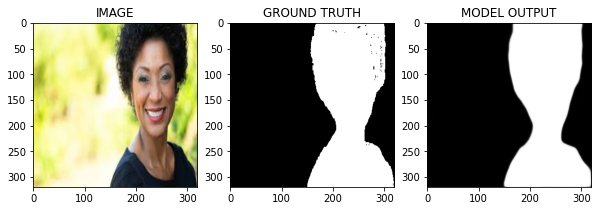

In [43]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))


Twitter : https://twitter.com/joselobenitezg

Linkedin : https://www.linkedin.com/in/josebenitezg/